In [27]:
import numpy as np
import numpy.random as rand
from scipy.constants import codata
import scipy.interpolate as si
from todloop.utils.pixels import PixelReader
from todloop.base import Routine, TODLoop
import cPickle
import os
import pprint
from todloop.utils.cuts import pixels_affected_in_event
from plot_glitches.routines import PlotGlitches
import moby2
from moby2.scripting import get_filebase
from random import *

%pylab inline

Populating the interactive namespace from numpy and matplotlib


/mnt/act3/users/jpm136/miniconda2/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['choice', 'uniform', 'shuffle', 'sample', 'f', 'rand', 'seed', 'randint', 'random', 'triangular']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [28]:
tod = 10000
input_dir="../outputs/s16_pa3_list/cosig/"
postfix = "pickle"
filepath = "%s%s.%s" % (input_dir, tod, postfix)
if os.path.isfile(filepath):
    with open(filepath, "r") as f:
        cuts = cPickle.load(f)
else:
    print 'Cosig data NOT loaded!'

fb = get_filebase()
loop = TODLoop()
loop.add_tod_list("../data/s16_pa3_list.txt")
loop.run(tod,tod+1)
tod_name = loop.get_name()
tod_filename = fb.filename_from_name(tod_name, single=True)  # get file path
tod_data = moby2.scripting.get_tod({'filename': tod_filename, 'repair_pointing': True})
amdata = moby2.scripting.get_array_data({'season' : '2016','array_name': 'AR3'})
sky_x = amdata['sky_x']
sky_y = amdata['sky_y']

#fix optical sign
optical_signs = tod_data.info.array_data['optical_sign']
tod_data.data = tod_data.data*optical_signs[:, np.newaxis]

#calibrate
cal = moby2.scripting.get_calibration({'type': 'iv', 'source': 'data'}, tod=tod_data)
cal_mask, cal_val = cal.get_property('cal', det_uid=tod_data.det_uid)
tod_data.data *= cal_val[:,None]
    
#print(cuts['coincident_signals'])
#cosig = cPickle.load(open(str(tod)+".pickle", "r"))
#cosig = cPickle.load(open("1111.pickle", "r"))

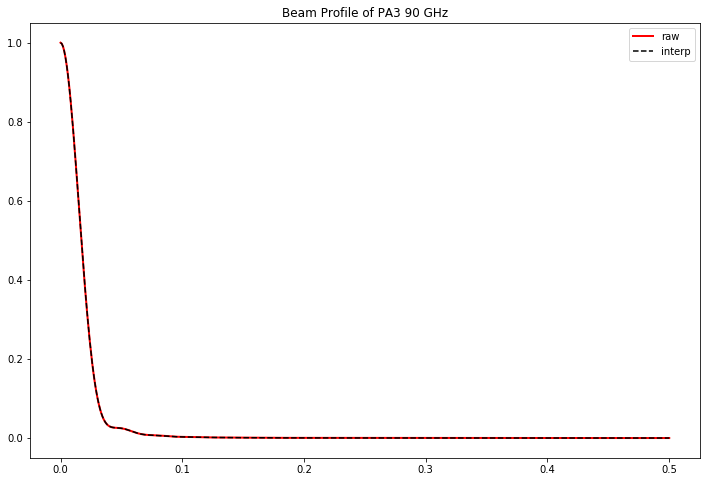

In [29]:
Beam_PA3_90 = np.loadtxt('beam_profile_170112_2015_pa3_90GHz_instant.txt', unpack=True, delimiter='  ', skiprows=4)

pa3_90x = Beam_PA3_90[0]
pa3_90y = Beam_PA3_90[1]
x = np.linspace(min(pa3_90x),max(pa3_90x),1000)
beam_profile = si.interp1d(pa3_90x,pa3_90y)

plt.figure(figsize=(12,8))
plt.title('Beam Profile of PA3 90 GHz')
plt.plot(pa3_90x,pa3_90y,'r',lw=2,label="raw")
plt.plot(x,beam_profile(x),'k--',label="interp")
plt.legend()


In [30]:
def Brightness_Temperature(Signal, Freq, Omega):
    """
    #------------------------------------------------#
    # Description: Computes the Brightness T in      #
    #              Kelvin for an FRB signal seen in  #
    #              the Atacama Cosmology Telescope.  #
    #                                                #
    # Parameters:                                    #
    #             Signal  : Signal Strength (Jy);    #
    #               Freq  : Frequency (GHz);         #
    #              Omega  : Solid Angle (sr);        #
    #------------------------------------------------#
    
    """
    
    # Boltzmann Constant:
    k_B = codata.value('Boltzmann constant')
    
    # Computes the radiation Wavelength (in meters):
    Lambda = 3e8/(Freq*1e9)
    
    # Jansky to J/m² Convertion:
    Jy_to_Jpm2 = 1e-26
    
    return ((Lambda**2)*Signal*Jy_to_Jpm2)/(2*k_B*Omega)


def Detector_Noise(Duration):
    """
    #------------------------------------------------#
    # Description: Computes the detector noise level #
    #              for a signal of given duration.   #
    #                                                #
    # Parameters:                                    #
    #             Duration  : Signal duration (ms);  #
    #------------------------------------------------#
    
    """
    
    # Average Detector Noise (in K√s):
    Av_Det_Noise = 400e-6
    
    # Computes the Noise Level:
    Noise_Level = Av_Det_Noise/np.sqrt(Duration/1000.)
    
    return Noise_Level

    
def Solid_Angle(Pol_Int, Az_Int, Beam):
    """
    #------------------------------------------------#
    # Description: Computes the instrument's beam    #
    #              solid angle integral for a given  #
    #              range of angles in spherical      #
    #              coordinates. 'Pol_Int' as well as #
    #              'Az_Int' must be a lists with two #
    #              elements each, determining the    #
    #              initial and final angles of       #
    #              integration for those variables.  #
    #              The 'Beam' must be an array of    #
    #              dimension 2 encapsulating the     #
    #              beam profile.                     #
    #                                                #
    # Parameters:                                    #
    #             Pol_Int  : Polar Angles (degrees); #
    #              Az_Int  : Azimuthal Angles (rad); #
    #                Beam  : Beam Profile;           #
    #------------------------------------------------#
    
    """
    
    # Converts the Beam Range to Radians:
    Range = Beam[0]*np.pi/180.
    
    # Computes the Azimuthal Integral:
    Phi_Partial = np.abs(Az_Int[1] - Az_Int[0])
    
    # Constructs a Filter Imposing the Polar Integration Limits:
    Filter = np.logical_and(Beam[0] > Pol_Int[0], Beam[0] < Pol_Int[1])
    
    # Computes the Polar Integration:
    Theta_Partial = np.trapz(Beam[1][Filter]*np.sin(Range[Filter]), Range[Filter])
    
    return Phi_Partial*Theta_Partial


def Solid_Angle_MC(Pol_Int, Az_Int, Beam):
    
    # Converts the Beam Range to Radians:
    Range = Beam[0]*np.pi/180.
    
    # Computes the Azimuthal Integral:
    Phi_Partial = np.abs(Az_Int[1] - Az_Int[0])
    
    # Constructs a Filter Imposing the Polar Integration Limits:
    Filter = np.logical_and(Beam[0] > Pol_Int[0], Beam[0] < Pol_Int[1])
    
    y = Beam[1][Filter]*np.sin(Range[Filter])
    x = Range[Filter]
    
    #Polar Integrand Function
    theta_f = si.interp1d(x,y)
    
    #For precision, increase this number
    nrectangles = 1000

    # Integration domain
    xlow = min(Range[Filter])
    xhigh = max(Range[Filter])

    # randomly distributed mid-points
    xvalues = xlow + (xhigh-xlow)*np.random.random(nrectangles) 
    fvalues = theta_f(xvalues) # f(x_i) for each rectangle
    areas = fvalues * (xhigh-xlow)/nrectangles # Area for each rectangle
    
    #Polar integral is sum of areas
    theta_integral = sum(areas)
   
    return theta_integral*Phi_Partial
    
  



In [62]:
print 'PA3 (90 GHz):'
omega_tot = Solid_Angle([0, 0.9/2.], [0, np.pi*2.], Beam_PA3_90)
omega_tot_mc = Solid_Angle_MC([0, 0.9/2.], [0, np.pi*2.], Beam_PA3_90)
omega_part = Solid_Angle([0.00, 0.055/2.], [0, 2*np.pi], Beam_PA3_90)
omega_part_mc = Solid_Angle_MC([0.00, 0.055/2.], [0, 2*np.pi], Beam_PA3_90)
omega_ratio = omega_part/omega_tot
omega_ratio_mc = omega_part_mc/omega_tot_mc
print 'Non Monte-Carlo Omega Ratio:', omega_ratio
print 'Monte-Carlo Omega Ratio:', omega_ratio_mc
print 'Total Solid Angle:', Solid_Angle([0, 0.9/2.], [0, 2*np.pi], Beam_PA3_90), 'sr'




a = 0.055
print 'Ratio of beam profile at angular separation of', a, '=', beam_profile(a)

PA3 (90 GHz):
Non Monte-Carlo Omega Ratio: 0.636731603120909
Monte-Carlo Omega Ratio: 0.5762377988079094
Total Solid Angle: 5.181628445594052e-07 sr
Ratio of beam profile at angular separation of 0.055 = 0.020870223246878


In [63]:
pr = PixelReader()
pg = PlotGlitches(tod_key="tod_data", cosig_key="cuts")
cs = cuts['coincident_signals']
#event = [203586, 203591, 5, 3] 
#event = [217833, 217837, 4, 4]
event = [163370, 163373, 3, 2]
stime = event[0]
etime = event[1]
pixels = pixels_affected_in_event(cs,event)

[593, 721]
XY Coordinates of Pixels in Degrees:
Distance of signal 1/ 5.0


593 : -0.17238157027078363 0.5600199504716703
Omega Ratio: 0.17439221314684827


721 : -0.17278345003427378 0.5058157450492972
Omega Ratio: 0.19294125178813457




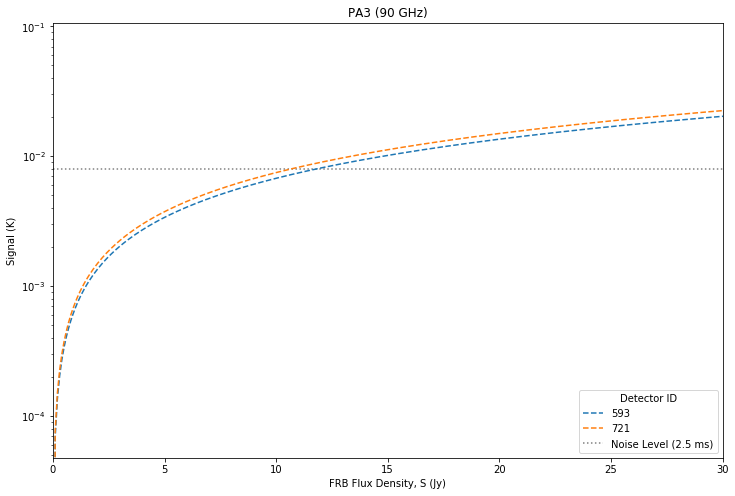

In [66]:
# Signal Range in Jansky:
Signal_Range = np.linspace(0, 100, 1000)

# Duration Range in Milliseconds:
Duration_Range = np.linspace(1, 10, 5)

plt.figure(figsize=(12,8))

print pixels
print 'XY Coordinates of Pixels in Degrees:'

distance = [1.,2.,3.,4.,5.,6.,7.,8.,9.,10.]
#l = random.choice(distance)
l = 5.
print 'Distance of signal 1/', l
print '\n'
for i,j in enumerate(pixels):
    x = sky_x[pixels[i]]
    y = sky_y[pixels[i]]
    z = .055 #dist between adjacent detectors
    omega_tot = Solid_Angle_MC([0, 0.9/l], [0, 2*np.pi], Beam_PA3_90)
    omega_part = Solid_Angle_MC([0.00, z/l], [0, 2*np.pi], Beam_PA3_90)
    omega_ratio = omega_part/omega_tot
    plt.plot(Signal_Range, Brightness_Temperature(Signal_Range, 90, 5.18162844559e-07)*omega_ratio/2.,'--', label=str(j))
    print j, ':', x, y
    print 'Omega Ratio:', omega_ratio
    print '\n'

plt.hlines(Detector_Noise(2.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dotted', label='Noise Level (2.5 ms)')    
#plt.hlines(Detector_Noise(7.5), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='dashed', label='T = 7.5 ms')
#plt.hlines(Detector_Noise(15), Signal_Range.min(), Signal_Range.max(), alpha=0.5, linestyle='solid', label='T = 15 ms')

plt.yscale('log')
plt.xlim([0, 30])

plt.xlabel('FRB Flux Density, S (Jy)')
plt.ylabel('Signal (K)')

plt.title ('PA3 (90 GHz)')
plt.legend(title='Detector ID',loc=4)
plt.show()

In [44]:
def timeseries(pixel_id, s_time, e_time, buffer=10):
    start_time = s_time - buffer
    end_time = e_time + buffer
    a1, a2 = pr.get_f1(pixel_id)
    d1, d2 = tod_data.data[a1], tod_data.data[a2]
    # try to remove the mean from start_time to end_time                                                                                                     
    d1 -= np.mean(d1[start_time:end_time])

    time = tod_data.ctime - tod_data.ctime[0]
    time = time[start_time:end_time]

    d_1 = d1[start_time:end_time]

    return time, d_1

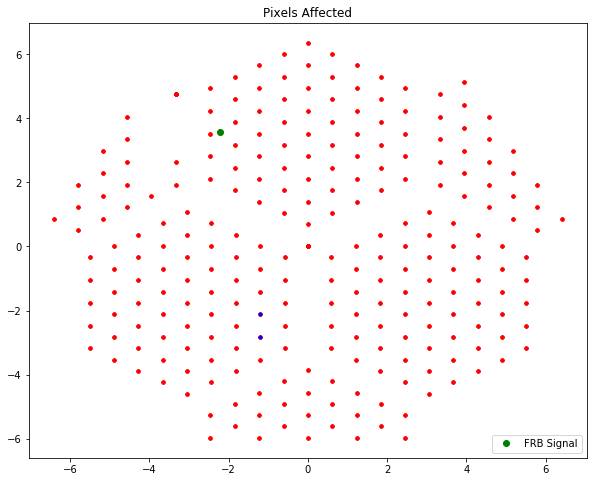

In [78]:
plt.figure(figsize=(10,8))
x,y = np.random.uniform(-7,7),np.random.uniform(-7,7)
pr.plot(pixels)
plt.plot(x,y,'go',label="FRB Signal")
plt.title('Pixels Affected')
plt.legend(loc=4)
plt.show()

Pixel Affected: 593
Adjacent Pixels: [208, 464, 465, 593, 594, 720, 721]
Ratios of adjacent signals: [7.12385095e-13 0.00000000e+00 5.66189881e-13 1.47095257e-11
 4.54735584e-12 9.01449906e-13 6.00497036e-12]


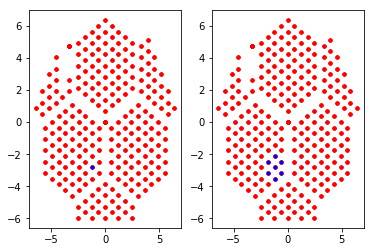

Pixel Affected: 721
Adjacent Pixels: [49, 50, 593, 594, 720, 721, 722]
Ratios of adjacent signals: [3.27739664e-13 0.00000000e+00 1.47095257e-11 4.54735584e-12
 9.01449906e-13 6.00497036e-12 3.23482659e-12]


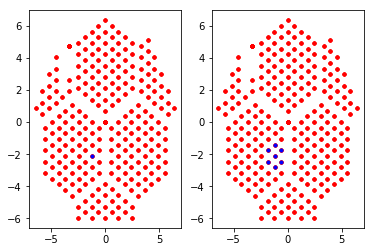

In [77]:
for i in pixels:
    j = pr.get_pixels_within_radius(i,1)
    x, y = timeseries(i,stime,etime)
    base_sig = max(y)
    max_sig = []
    for n in j:
        a,b = timeseries(n,stime,etime)
        max_sig.append(max(b))
    ratios = np.asarray(max_sig)
    ratios/base_sig
    print 'Pixel Affected:', i 
    print 'Adjacent Pixels:', j
    print 'Ratios of adjacent signals:', ratios
    plt.subplot(121)
    pr.plot(i)
    
    plt.subplot(122)
    pr.plot(j)
    plt.show()
    
#x, y = timeseries(527,stime,etime)
#plt.plot(x,y)
#plt.show()

In [47]:
from scipy.optimize import curve_fit
Beam_PA3_90 = np.loadtxt('beam_profile_170112_2015_pa3_90GHz_instant.txt', unpack=True, delimiter='  ', skiprows=4)

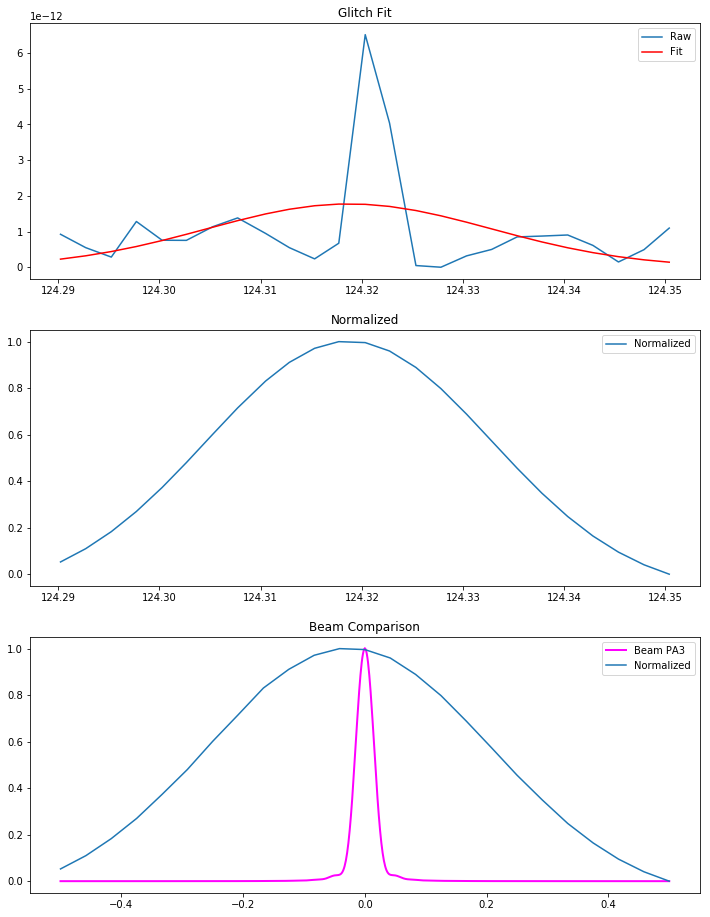

In [48]:
#use 271 for first event 
pid = pixels[0]

x, y = timeseries(pid,stime,etime)
y += abs(min(y))
mean = sum(x * y) / sum(y)
sigma = np.sqrt(sum(y * (x - mean)**2) / sum(y))

def Gauss(x, a, x0, sigma):
    return a * np.exp(-(x - x0)**2 / (2 * sigma**2))

popt,pcov = curve_fit(Gauss, x, y, p0=[max(y), mean, sigma])
y2 = Gauss(x, *popt)
normalized = (y2-min(y2))/(max(y2)-min(y2))
beam_x = np.linspace(-0.5,0.5,len(normalized))

plt.figure(figsize=(12,16))
plt.subplot(311)
plt.title('Glitch Fit')
plt.plot(x,y,label="Raw")
plt.plot(x, y2, 'r-', label='Fit')
plt.legend()

plt.subplot(312)
plt.plot(x,normalized,label="Normalized")
plt.title('Normalized')
plt.legend()


plt.subplot(313)
plt.title('Beam Comparison')
plt.plot(Beam_PA3_90[0], Beam_PA3_90[1], color='magenta', linewidth=2)
plt.plot(-Beam_PA3_90[0], Beam_PA3_90[1], color='magenta', linewidth=2,label="Beam PA3")
plt.plot(beam_x,normalized, label="Normalized")
plt.legend()
plt.show()